In [32]:
#General packages
import os
import numpy as np
from tqdm import tqdm  ### package for progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### MODEL 1 infrastructure
import pandas as pd
from model1_class import Model1
from run_enkf import *
### MODEL 2 infrastructure
from model2_class import Model2
#from run_both_models_n_times_and_compute_error import *
import import_ipynb
import matplotlib.ticker as mtick
tqdm.pandas()

#%%


class Experiment1:
    def __init__(self, num_agents, ensemble_size, macro_state_dim, start_year, end_year, filter_freq):
        self.num_agents = num_agents
        self.ensemble_size = ensemble_size
        self.macro_state_dim = macro_state_dim
        self.enkf1 = None
        self.enkf2 = None
        self.start_year = start_year
        self.end_year = end_year

    def run_both_enkf(self, filter_freq):
        
        model_params1 = {"population_size": self.num_agents,
                        "growth_rate": 0.025,
                        "b_begin": 1.3,
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "uncertainty_para": 0.1}
        
        model_params2 = {"population_size": self.num_agents, 
                        "concavity": 1,
                        "growth_rate": 0.025, 
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "adaptive_sensitivity": 0.02,
                        "uncertainty_para": 0}

        
        self.enkf1 = prepare_enkf(Model1,
                                  model_params= model_params1,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        self.enkf2 = prepare_enkf(Model2,
                                   model_params= model_params2,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        run_enkf(self.enkf1, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)
        run_enkf(self.enkf2, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)

    def plot_results(self):

        fig = plt.figure(figsize=(10, 10))
        # Create a gridspec object
        gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
        # Create individual subplots
        ax0 = plt.subplot(gs[0, 0])
        ax1 = plt.subplot(gs[0, 1])
        ax2 = plt.subplot(gs[1, 0])
        ax3 = plt.subplot(gs[1, 1])
        ax4 = plt.subplot(gs[2, :])  # This one spans both columns

        
        self.enkf1.models[0].plot_wealth_groups_over_time(ax0, self.start_year, self.end_year)
        self.enkf2.models[0].plot_wealth_groups_over_time(ax1, self.start_year, self.end_year)
        self.enkf1.plot_fanchart(ax2)
        self.enkf2.plot_fanchart(ax3)        
        self.enkf1.plot_error(ax4)
        self.enkf2.plot_error(ax4)

        ###EXTRAS
        #AX0
        ax0.text(0, 0.85, 'A', fontsize = 12)
        ax0.text(40, 0.85, 'Model 1', fontsize = 12)
        #AX1
        ax1.legend(loc=(1.05, -0.15), frameon = False) ### legend only here
        ax1.text(0, 0.85, 'B', fontsize = 12)
        ax1.text(40, 0.85, 'Model 2', fontsize = 12)
        #AX2
        ax2.text(0, 1.05, 'C', fontsize = 12)
        ax2.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
        ax2.text(40,1.05, 'Model 1', fontsize = 12)
        #AX3
        ax3.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%', '100%'])
        ax3.text(0,1.05, 'D', fontsize = 12)
        ax3.text(40,1.05, 'Model 2', fontsize = 12)

        path = '..'
        with open(os.path.join(path, 'data', 'mean_errors.csv')) as f:
            errors_df_no_enkf = pd.read_csv(f, encoding='unicode_escape')

        ax4.plot(errors_df_no_enkf['mean_error_model1'], linestyle='--', label='Model 1 no ENKF', color='tab:blue')
        ax4.plot(errors_df_no_enkf['mean_error_model2'], linestyle='--', label='Model 2 no ENKF', color='tab:orange')
        ax4.legend(bbox_to_anchor=(1.05, 1), frameon=False)
        
        # Get the limits
        x_min, x_max = ax4.get_xlim()
        y_min, y_max = ax4.get_ylim()
        ax4.text(0, y_max+0.02, 'E', fontsize = 12)
        ax4.margins(0)


        plt.tight_layout()
        plt.savefig('fig4.png', dpi=300)
        plt.show()
         
        
# Example usage
if __name__ == "__main__":
    filter_freq = 30
    experiment1 = Experiment1(num_agents=100, 
                              ensemble_size=100, 
                              macro_state_dim=4, 
                              start_year=1990,
                              end_year=2022,
                              filter_freq = filter_freq)
    experiment1.run_both_enkf(filter_freq = filter_freq)
    experiment1.plot_results()
    agent_states_model1 = experiment1.enkf1.micro_history
    agent_states_model2 = experiment1.enkf2.micro_history
    #experiment1.enkf1.plot_macro_state()

    # get eigenvalues of model 2
    eigenvalues_model2 = experiment1.enkf2.eigenvalues_diff_history

## Analysis of numerical instability and filter behaviour during update step

In [ ]:

update_step_choice = 0

# MODEL 2 ENKF analysis
# get data ensemble, state ensemble, H, Kalman Gain

data_ensemble_history = experiment1.enkf2.data_ensemble_history
state_ensemble_history = experiment1.enkf2.state_ensemble_history	
H = experiment1.enkf2.H
Kalman_Gain_history = experiment1.enkf2.Kalman_Gain_history 
diff_history  = experiment1.enkf2.diff_history 
print(data_ensemble_history[update_step_choice].shape)
print(state_ensemble_history[update_step_choice].shape)
print(H.shape)
print(Kalman_Gain_history[update_step_choice].shape)
print(diff_history[update_step_choice].shape)

# print first element data ensemble and state ensemble and Kalman Gain
print('this data ensemble history model 2', data_ensemble_history[update_step_choice])
print('this is state ensemble history model 2', state_ensemble_history[update_step_choice])
print('this is Kalman Gain history model 2', Kalman_Gain_history[update_step_choice])
print('this is diff history model 2', diff_history[update_step_choice])

# analyse variance of data ensemble
variance_data_ensemble = np.var(data_ensemble_history[update_step_choice], axis = 1)
print('this is variance of data ensemble model 2', variance_data_ensemble)

# MODEL 1 ENKF analysis
# get data ensemble, state ensemble, H, Kalman Gain


data_ensemble_historyMODEL1 = experiment1.enkf1.data_ensemble_history
state_ensemble_historyMODEL1= experiment1.enkf1.state_ensemble_history	
H = experiment1.enkf1.H
Kalman_Gain_historyMODEL1 = experiment1.enkf1.Kalman_Gain_history 
diff_historyMODEL1  = experiment1.enkf1.diff_history
print(data_ensemble_historyMODEL1[update_step_choice].shape)
print(state_ensemble_historyMODEL1[update_step_choice].shape)
print(H.shape)
print(Kalman_Gain_historyMODEL1[update_step_choice].shape)


# print first element data ensemble and state ensemble and Kalman Gain
print('this data ensemble history model 1', data_ensemble_historyMODEL1[update_step_choice])
print('this is state ensemble history model 1', state_ensemble_historyMODEL1[update_step_choice])
print('this is Kalman Gain history model 1', Kalman_Gain_historyMODEL1[update_step_choice])
print('this is diff history model 1', diff_historyMODEL1[update_step_choice])

# analyse variance of data ensemble
variance_data_ensemble = np.var(data_ensemble_historyMODEL1[update_step_choice], axis = 1)
print('this is variance of data ensemble model 1', variance_data_ensemble)






(4, 100)
(100, 100)
(4, 100)
(100, 4)
(4, 100)
this data ensemble history model 2 [[ 5.62697156e+06  6.71748176e+06  6.15276469e+06  9.32988797e+06
   5.77378587e+06  8.57596054e+06  1.37226198e+06  2.43255143e+06
   4.83079596e+06 -9.98534681e+05  4.63356801e+06  5.36250821e+06
   1.17166568e+07  5.64729891e+06  9.20242862e+06  1.40976598e+06
   4.14599204e+06  4.65932476e+06  1.01391380e+07  4.11999271e+06
  -1.01906479e+06  5.92775974e+06  2.69443726e+06  3.15294551e+06
   1.00795533e+07  7.39170913e+06  5.86450376e+06  5.97035574e+06
   3.58679524e+06  5.55355642e+06  8.86035433e+06  6.82729507e+06
   8.41008457e+06  2.96298670e+06  5.56970132e+06  6.08337542e+06
   8.73160597e+06  4.89724926e+06  1.10898331e+07  7.61217629e+06
   4.44144478e+06  5.46820595e+06  1.49229823e+06  6.47643393e+06
   7.23200572e+06  7.99899600e+06  7.91039049e+06  1.57939256e+06
   1.19714818e+06  8.01147051e+06  3.86323327e+06  2.55655730e+06
   5.77392787e+06  8.59236799e+06  4.36976802e+06  2.9555775

## Plot agent-state variables and how the ENKF affects them

### Collect data from model 1

In [ ]:
# Initialize an empty list to store the data
data = []
# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model1):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data.append(df)

# Concatenate the list into a single DataFrame
result_df = pd.concat(data, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df.columns = [f'ensemble_member_{i}' for i in range(result_df.shape[1] - 1)] + ['time_step']

print(result_df.head())


              0             1             2             3             4  \
0  1.796887e+06  1.952549e+06  3.465307e+06  9.510659e+06  1.561440e+06   
1  1.362841e+06  1.016962e+06  2.216240e+06  4.165030e+06  1.274413e+06   
2  9.620161e+05  6.418005e+05  1.307767e+06  2.651337e+06  1.124465e+06   
3  8.136181e+05  6.385303e+05  1.076148e+06  1.833710e+06  9.324048e+05   
4  7.665699e+05  5.628187e+05  8.111457e+05  1.326624e+06  6.361954e+05   

              5             6             7             8             9  ...  \
0  2.549463e+07  1.216679e+06  2.920066e+06  9.864611e+06  1.968721e+06  ...   
1  6.685447e+06  1.203722e+06  1.897652e+06  3.530259e+06  1.899859e+06  ...   
2  4.211669e+06  8.173358e+05  1.318361e+06  3.260589e+06  1.818673e+06  ...   
3  7.060056e+05  8.149268e+05  1.287101e+06  1.564981e+06  1.724567e+06  ...   
4  6.325750e+05  7.397993e+05  7.178114e+05  8.819922e+05  1.499308e+06  ...   

             91            92            93            94           

### Collect data from model 2

In [ ]:
# Initialize an empty list to store the data
data_model2 = []

# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model2):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data_model2.append(df)

# Concatenate the list into a single DataFrame
result_df_model2 = pd.concat(data_model2, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df_model2.columns = [f'ensemble_member_{i}' for i in range(result_df_model2.shape[1] - 1)] + ['time_step']

print(result_df_model2.head())


              0             1             2             3             4  \
0  1.403299e+07  1.746919e+06  2.286279e+06  2.331749e+06  3.245838e+06   
1  1.253678e+07  1.108296e+06  1.820833e+06  1.161494e+06  2.149223e+06   
2  4.170951e+06  8.563160e+05  1.695915e+06  1.047957e+06  2.113100e+06   
3  1.500161e+06  8.495792e+05  1.282909e+06  9.794885e+05  1.483658e+06   
4  1.340214e+06  8.126057e+05  1.090199e+06  8.005513e+05  1.221274e+06   

              5             6             7             8             9  ...  \
0  4.960803e+06  1.056773e+07  2.912825e+06  3.359733e+07  4.350041e+06  ...   
1  4.124844e+06  1.319518e+06  1.739950e+06  1.698444e+07  1.962139e+06  ...   
2  1.366344e+06  8.639398e+05  9.722186e+05  6.421342e+06  1.075612e+06  ...   
3  1.183527e+06  8.555399e+05  9.733340e+05  5.669263e+06  1.004879e+06  ...   
4  1.047295e+06  7.878214e+05  8.859649e+05  2.748723e+06  8.463840e+05  ...   

             91            92            93            94           

## Try plotting average of ensembles evolution

c:\Users\yoswald\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\yoswald\AppData\Local\Temp\ipykernel_18696\3828414789.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_avg['log_wealth'] = np.log(result_df_avg['average_wealth'])
c:\Users\yoswald\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\yoswald\AppData\Local\Temp\ipykernel_18696\3828414789.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Text(0.5, 1.0, 'Model 2')

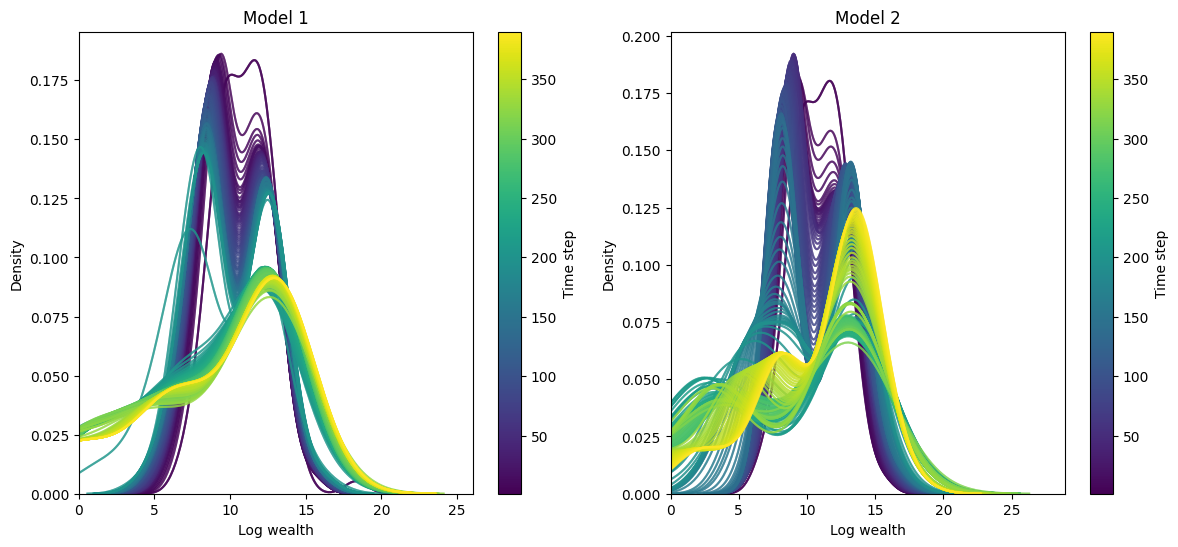

In [ ]:

# import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# build average of all ensemble members
result_df['average_wealth'] = result_df.iloc[:, 1:-1].mean(axis=1)
result_df_avg = result_df[['time_step', 'average_wealth']]

# log transform the average data
result_df_avg['log_wealth'] = np.log(result_df_avg['average_wealth'])

# loop over time steps and plot all data as kernel density estimates with a colormap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=390)

for time_step in range(1, 390):
    color = cmap(norm(time_step))
    sns.kdeplot(result_df_avg[result_df_avg['time_step'] == time_step]['log_wealth'], ax=ax1, color=color, label=f'Time step {time_step}', alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label('Time step')
ax1.set_xlabel('Log wealth')
ax1.set_ylabel('Density')
# set left x axis limit at 0
ax1.set_xlim(left=0)
ax1.set_title('Model 1')


## Model 2
# build average of all ensemble members
result_df_model2['average_wealth'] = result_df_model2.iloc[:, 1:-1].mean(axis=1)
result_df_avg_model2 = result_df_model2[['time_step', 'average_wealth']]
# log transform the average data
result_df_avg_model2['log_wealth'] = np.log(result_df_avg_model2['average_wealth'])

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=390)
for time_step in range(1, 390):
    color = cmap(norm(time_step))
    sns.kdeplot(result_df_avg_model2[result_df_avg_model2['time_step'] == time_step]['log_wealth'], ax=ax2, color=color, label=f'Time step {time_step}', alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label('Time step')
ax2.set_xlabel('Log wealth')
ax2.set_ylabel('Density')
# set left x axis limit at 0
ax2.set_xlim(left=0)
ax2.set_title('Model 2')

## Plot first update state average across ensemble members vs. observations as well

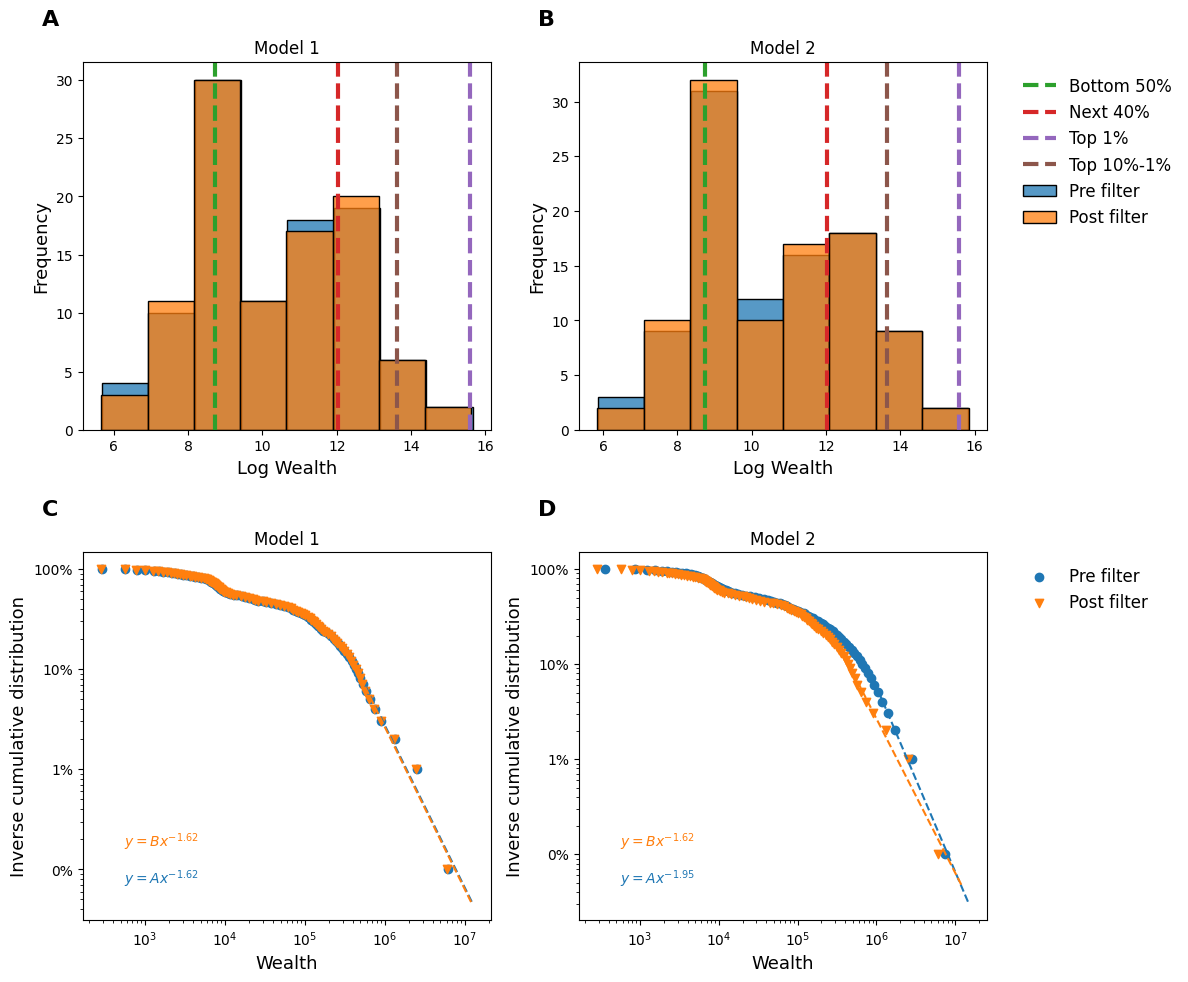

In [ ]:
# Load the empirical data
path = '..'
with open(os.path.join(path, 'data', 'wealth_data_for_import.csv')) as f:
    wealth_data = pd.read_csv(f, encoding='unicode_escape')


# Plot time step 20 and 40 kernel density estimates of the log values
# Plot kernel density estimates and empirical data in a 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# First model KDE plots
sns.histplot(result_df_avg[result_df_avg['time_step'] == 31]['log_wealth'], ax=ax1, label='Time step 31: Pre filter', color='tab:blue')
sns.histplot(result_df_avg[result_df_avg['time_step'] == 32]['log_wealth'], ax=ax1, label='Time step 32: Post filter', color='tab:orange')

# Subset the data to the years 1990-2022
wealth_data = wealth_data[(wealth_data['year'] >= 1990) & (wealth_data['year'] <= 2022)]
# Subset wealth data based on column year being 1992 and month column being 7
wealth_data_empirical = wealth_data[(wealth_data['year'] == 1992) & (wealth_data['month'] == 7)]
# Subset the column real_wealth_per_unit only and log transform the data
wealth_data_empirical_log = np.log(wealth_data_empirical['real_wealth_per_unit'])

# Plot vertical lines for the empirical data
empirical_labels = ['Bottom 50%', 'Next 40%', 'Top 1%', 'Top 10%-1%']
empirical_colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown']
for i, (value, label, color) in enumerate(zip(wealth_data_empirical_log, empirical_labels, empirical_colors)):
    ax1.axvline(value, color=color, linestyle='--', linewidth=3, label=label)
    ax2.axvline(value, color=color, linestyle='--', linewidth=3, label=label)

# Second model KDE plots
sns.histplot(result_df_avg_model2[result_df_avg_model2['time_step'] == 31]['log_wealth'], ax=ax2, label='Pre filter', color='tab:blue')
sns.histplot(result_df_avg_model2[result_df_avg_model2['time_step'] == 32]['log_wealth'], ax=ax2, label='Post filter', color='tab:orange')

# Adjust layout to fit legends outside the plots
fig.tight_layout(rect=[0, 0, 0.85, 1])

fontsize_axislabels = 13

# Place the legend outside the second subplot
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 12, frameon=False)

# Set titles and labels
ax1.set_title('Model 1')
ax1.set_xlabel('Log Wealth', fontsize=fontsize_axislabels)
ax1.set_ylabel('Frequency', fontsize=fontsize_axislabels)

ax2.set_title('Model 2')
ax2.set_xlabel('Log Wealth', fontsize=fontsize_axislabels)
ax2.set_ylabel('Frequency', fontsize=fontsize_axislabels)

ax3.set_title('Model 1')
ax4.set_title('Model 2')

# Plot the non log wealth as inverse cumulative distribution
values_model1_pre_update = np.sort(result_df_avg[result_df_avg['time_step'] == 31]['average_wealth'])
values_model1_post_update = np.sort(result_df_avg[result_df_avg['time_step'] == 32]['average_wealth'])
# make cumulative percentiles of values
percentiles = np.linspace(0, 100, len(values_model1_pre_update))/100
# plot the percentiles
inv_cumulative = 1-percentiles
# last value add tiny positive value to avoid log(0)
inv_cumulative[-1] = inv_cumulative[-1] + 1e-3
# plot the percentiles
ax3.scatter(values_model1_pre_update, inv_cumulative, label='Pre filter', color='tab:blue')
ax3.scatter(values_model1_post_update, inv_cumulative, label='Post filter', color='tab:orange', marker = "v")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('Wealth', fontsize=fontsize_axislabels)
ax3.set_ylabel('Inverse cumulative distribution', fontsize=fontsize_axislabels)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))



# Plot the non log wealth as inverse cumulative distribution
values_model2_pre_update = np.sort(result_df_avg_model2[result_df_avg_model2['time_step'] == 31]['average_wealth'])
values_model2_post_update = np.sort(result_df_avg[result_df_avg['time_step'] == 32]['average_wealth'])
# make cumulative percentiles of values
percentiles = np.linspace(0, 100, len(values_model2_pre_update))/100

ax4.scatter(values_model2_pre_update, inv_cumulative, label='Pre filter', color='tab:blue')
ax4.scatter(values_model2_post_update, inv_cumulative, label='Post filter', color='tab:orange', marker = "v")
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('Wealth', fontsize=fontsize_axislabels)
ax4.set_ylabel('Inverse cumulative distribution', fontsize=fontsize_axislabels)
ax4.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, frameon=False)


# Label the panels
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, size=16, weight='bold')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, size=16, weight='bold')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, size=16, weight='bold')
ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, size=16, weight='bold')




# make the power law fits for panel 1 and panel 2 
last7 = values_model1_pre_update[-7:]
# last 7 percentiles
inv_cumulative_last7 = inv_cumulative[-7:]
# make linear fit of last7 as x and percentiles_last7 as y
slope, intercept = np.polyfit(np.log(last7), np.log(inv_cumulative_last7), 1)
# make power law fit with the slope and intercept
# Create dummy data using the min of last7 and max of last7 times 2
x_dummy = np.linspace(min(last7), max(last7) * 2, 100)
power_law = np.exp(slope*np.log(x_dummy) + intercept)
ax3.plot(x_dummy, power_law, label='Power law fit', color='tab:blue', linestyle='--')
# plot equation lower left corner of ax3
ax3.text(0.1, 0.1, f'$y = Ax^{{{slope:.2f}}}$', transform=ax3.transAxes, color='tab:blue')


# do fit for the  values_model1_post_update
last7 = values_model1_post_update[-7:]
# last 7 percentiles
inv_cumulative_last7 = inv_cumulative[-7:]
# make linear fit of last7 as x and percentiles_last7 as y
slope, intercept = np.polyfit(np.log(last7), np.log(inv_cumulative_last7), 1)
# make power law fit with the slope and intercept
x_dummy = np.linspace(min(last7), max(last7) * 2, 100)
power_law = np.exp(slope*np.log(x_dummy) + intercept)
ax3.plot(x_dummy, power_law, label='Power law fit', color='tab:orange', linestyle='--')
# plot equation lower left corner of ax3
ax3.text(0.1, 0.2, f'$y = Bx^{{{slope:.2f}}}$', transform=ax3.transAxes, color='tab:orange')

# do the fit for the model 2 values_model2_pre_update
last7 = values_model2_pre_update[-7:]
# last 7 percentiles
inv_cumulative_last7 = inv_cumulative[-7:]
# make linear fit of last7 as x and percentiles_last7 as y
slope, intercept = np.polyfit(np.log(last7), np.log(inv_cumulative_last7), 1)
# make power law fit with the slope and intercept
x_dummy = np.linspace(min(last7), max(last7) * 2, 100)
power_law = np.exp(slope*np.log(x_dummy) + intercept)
ax4.plot(x_dummy, power_law, label='Power law fit', color='tab:blue', linestyle='--')
# plot equation lower left corner of ax3
ax4.text(0.1, 0.1, f'$y = Ax^{{{slope:.2f}}}$', transform=ax4.transAxes, color='tab:blue')


# do fit for the  values_model2_post_update
last7 = values_model2_post_update[-7:]
# last 7 percentiles
inv_cumulative_last7 = inv_cumulative[-7:]
# make linear fit of last7 as x and percentiles_last7 as y
slope, intercept = np.polyfit(np.log(last7), np.log(inv_cumulative_last7), 1)
# make power law fit with the slope and intercept
x_dummy = np.linspace(min(last7), max(last7) * 2, 100)
power_law = np.exp(slope*np.log(x_dummy) + intercept)
ax4.plot(x_dummy, power_law, label='Power law fit', color='tab:orange', linestyle='--')
# plot equation lower left corner of ax4
ax4.text(0.1, 0.2, f'$y = Bx^{{{slope:.2f}}}$', transform=ax4.transAxes, color='tab:orange')

plt.tight_layout()

plt.savefig('fig5.png', dpi=300)

